In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder

In [2]:
pkl_file = open('./JoinedData.pkl','rb')
df = pickle.load(pkl_file)
pkl_file.close()
labelEncoder = LabelEncoder()
df['Origin'] = labelEncoder.fit_transform(df['Origin'])
df['Dest'] = labelEncoder.fit_transform(df['Dest'])


In [3]:
df.columns


Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'FlightDate', 'Origin',
       'Dest', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'NearestDepTime',
       'totalSnow_cm', 'date', 'windspeedKmph', 'DewPointF', 'cloudcover',
       'precipMM', 'pressure', 'WindGustKmph', 'visibility', 'weatherCode',
       'tempF', 'WindChillF', 'winddirDegree', 'humidity', 'time'],
      dtype='object')

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklear.metrics import *

In [5]:
df.dropna(how='any',inplace=True)
df.drop(columns=['FlightDate','date','Origin','ArrTime','ArrDelayMinutes','CRSArrTime','NearestDepTime'],inplace=True)
X = df.loc[:, df.columns != 'ArrDel15']
y = df.loc[:, df.columns == 'ArrDel15']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.25)

In [6]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

Using TensorFlow backend.


In [7]:
df.shape

(1851115, 23)

In [8]:
classifier =  LogisticRegression(random_state=42,max_iter=10000)
classifier.fit(X_train_res,y_train_res)

/home/mahesh/miniconda3/envs/icell/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
pickle.dump(classifier,open('./TrainedModels/LogisticRegression.pkl','wb'))

In [11]:
y_pred = classifier.predict(X_test)

In [12]:
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.896


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93    365730
         1.0       0.74      0.78      0.76     97049

    accuracy                           0.90    462779
   macro avg       0.84      0.85      0.85    462779
weighted avg       0.90      0.90      0.90    462779



In [14]:
cm = confusion_matrix(y_test, y_pred)  
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[339041  26689]
 [ 21359  75690]]


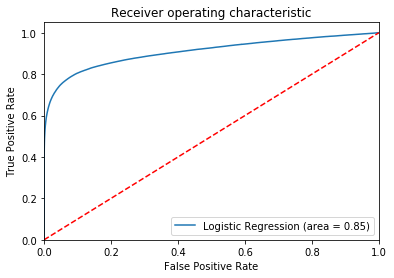

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('./Images/LogisticRegressorROC.png')
plt.show()

# Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
print(X_train.shape)
print(X_train_res.shape)
print(y_train.shape)
print(y_train_res.shape)

(1388336, 22)
(2194874, 22)
(1388336, 1)
(2194874, 1)


In [19]:
classifier_tree  = DecisionTreeClassifier(max_depth = 100,random_state = 0)
classifier_tree.fit(X_train_res,y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [20]:
pickle.dump(classifier_tree,open('./TrainedModels/DecisionTreeClassifier.pkl','wb'))

In [21]:
y_pred = classifier_tree.predict(X_test)

In [22]:
classifier_tree.get_depth()

61

In [23]:
score = classifier_tree.score(X_test,y_test)
print(score)

0.8656507749919508


In [24]:
importances = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(classifier_tree.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False)
importances

,Feature,Importance
7,DepDelayMinutes,0.717
0,Year,0.034
6,DepTime,0.022
1,Quarter,0.022
19,winddirDegree,0.019
12,precipMM,0.019
5,CRSDepTime,0.018
4,Dest,0.017
3,DayofMonth,0.014
20,humidity,0.014


In [25]:
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[332621  33109]
 [ 29065  67984]]


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91    365730
         1.0       0.67      0.70      0.69     97049

    accuracy                           0.87    462779
   macro avg       0.80      0.80      0.80    462779
weighted avg       0.87      0.87      0.87    462779



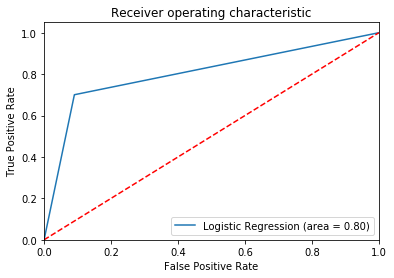

In [27]:
logit_roc_auc = roc_auc_score(y_test, classifier_tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier_tree.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('./Images/DecisionTreeClassifierROC.png')
plt.show()

# XGBoost Classifier

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
model = GradientBoostingClassifier(max_depth=5)
model.fit(X_train_res,y_train_res)

/home/mahesh/miniconda3/envs/icell/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [30]:
pickle.dump(model,open('./TrainedModels/XGBoostClassifier.pkl','wb'))

In [31]:
y_pred = model.predict(X_test)

In [32]:
#After XGBoost
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95    365730
         1.0       0.85      0.72      0.78     97049

    accuracy                           0.91    462779
   macro avg       0.89      0.84      0.86    462779
weighted avg       0.91      0.91      0.91    462779



In [33]:
cm = confusion_matrix(y_test, y_pred)  
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[353287  12443]
 [ 27275  69774]]


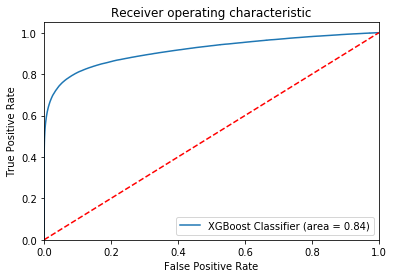

In [42]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('./Images/XGBoostClassifier.png')
plt.show()

# Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rfc_model = RandomForestClassifier(random_state=42,n_jobs=3)
rfc_model.fit(X_train_res,y_train_res)

/home/mahesh/miniconda3/envs/icell/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [45]:
pickle.dump(rfc_model,open('./TrainedModels/RandomForestClassifier.pkl','wb'))

In [46]:
y_pred = rfc_model.predict(X_test)

In [47]:
#After Random Forest Classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95    365730
         1.0       0.83      0.73      0.78     97049

    accuracy                           0.91    462779
   macro avg       0.88      0.85      0.86    462779
weighted avg       0.91      0.91      0.91    462779



In [48]:
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[351661  14069]
 [ 26089  70960]]


In [ ]:
logit_roc_auc = roc_auc_score(y_test, rfc_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('./Images/RandomForestClassifierROC.png')
plt.show()